In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import time
import os.path
import pickle

In [2]:
df = pd.read_csv("mock_data.csv")

In [3]:
df2 = pd.read_csv("data.csv")

In [4]:
df2.head()

,Class,Ecosystem,Species,Genus,Order
0,Mammals,Savannahs,Zebra,Equus,Perissodactyla
1,Mammals,Savannahs,Giraffe,Giraffa,Artiodactyla
2,Mammals,Savannahs,Elephant,Loxodonta,Proboscidea
3,Mammals,Savannahs,Hyena,Hyaena,Carnivora
4,Mammals,Savannahs,Lion,Panthera,Carnivora


In [5]:
def load_cache():
    pickle_path = "data_cache.pkl"
    file_exists = os.path.exists(pickle_path)
    if file_exists:
        with open( pickle_path, 'rb') as f:
            print(f"loading cache from {pickle_path}")
            return pickle.load(f)
    else:
        return {}
    
cache = load_cache()

loading cache from data_cache.pkl


In [14]:
def save_cache(cache):
    pickle_path = "data_cache.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump(cache, f, pickle.HIGHEST_PROTOCOL)
save_cache(cache)

In [66]:
def calc_avg_w():
    acc = np.zeros(3)
    n = len(cache)
    for v in cache.values():
        acc = acc + v
    return acc / n

agg_w = calc_avg_w()

# generates a list of species name grouped by col_name
def gen_sets_by_col(df, col_name):
    classes = df[col_name].unique()
    all_set = []
    for c in classes:
        s = list(df[df[col_name] == c]["Species"])
        all_set.extend(s)
    return all_set

# TODO: what if the page doesn't exists?
def findDegrees(source, target):
    payload = {"source": source, "target": target}
    headers = {'Accept': 'application/json, text/plain, */*', 'Content-Type': 'application/json;charset=UTF-8'}
    url = 'https://api.sixdegreesofwikipedia.com/paths'
    response = requests.post(url, data=json.dumps(payload), headers=headers)
    number_of_degrees = len(response.json()['paths'][0]) - 1
    number_of_paths = len(response.json()['paths'])

    occurrences = [0, 0, 0]

    if number_of_degrees == 1:
        occurrences[0] = number_of_paths
    elif number_of_degrees == 2:
        occurrences[1] = number_of_paths
    else:
        occurrences[2] = number_of_paths

    return occurrences


# calculates the similarity
def sim(source, target):
#     print(f"findDegrees: {source} to {target} -----")
    # TODO: find appropriate weights
    # explain in report why those weights are chosen
    w = np.array([1, 1, 1])
    pair1 = (source, target)
    pair2 = (target, source)
    if pair1 in cache:
        d1 = cache[pair1]
    else:
        d1 = np.asarray(findDegrees(source, target))
        cache[pair1] = d1
    if pair2 in cache:
        d2 = cache[pair2]
    else:
        d2 = np.asarray(findDegrees(target, source))
        cache[pair2] = d2
    avg_link = (d1 + d2) / 2
    norm_link = avg_link / agg_w
#     print(avg_link)
    return np.sum(w * norm_link)

# generate the simularity matrix
# Note that the matrix is symmetric because sim(x,y) == sim(y,x)
def gen_matrix(lst):
    n = len(lst)
    arr = np.zeros((n,n))
    for i in range(n):
        for j in range(i + 1):
            if arr[i][j] != 0:
                continue
            if (i == j):
                # TODO: hard a sensible value
                # arr[i][i] = sim(lst[i], lst[i])
                arr[i][i] = 0
            else:
                t = sim(lst[i], lst[j])
                arr[i][j] = t
                arr[j][i] = t
    return arr

# generates a meatmap from the data frame df grouped by col_name
def gen_heatmap(df,col_name):
    lst = gen_sets_by_col(df, col_name)
    start_time = time.time()
    sim_mat = gen_matrix(lst)
    end_time = time.time()
    print(f"time matrix creation time: {end_time - start_time} sec")
    ax = sns.heatmap(sim_mat, cbar_kws={'label': 'Similarity value'})
    plt.xlabel("index of animal") 
    plt.ylabel("index of animal")
    plt.title(f"Similarities between animals by {col_name}")
    plt.show() 

In [ ]:
# heat map for test data
gen_heatmap(df, "Class")

time matrix creation time: 0.07553982734680176 sec


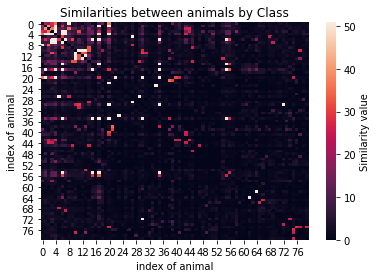

time matrix creation time: 0.06713700294494629 sec


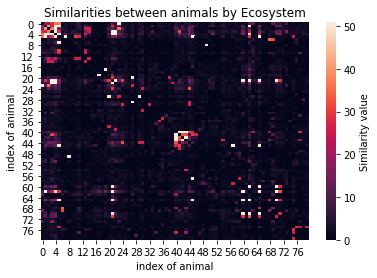

time matrix creation time: 0.06170225143432617 sec


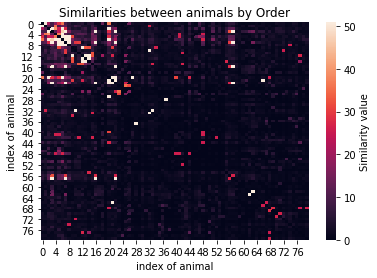

time matrix creation time: 0.06233978271484375 sec


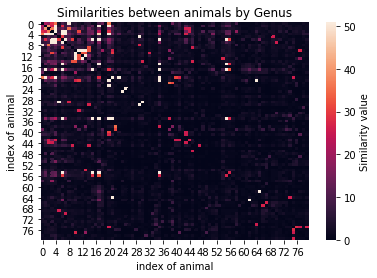

In [69]:
# heat map for actual data
gen_heatmap(df2, "Class")
gen_heatmap(df2, "Ecosystem")
gen_heatmap(df2, "Order")
gen_heatmap(df2, "Genus")

In [ ]:
# heat map for actual data
gen_heatmap(df2, "")

79.74960814950754